In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 9

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 1000)
GT S-parameters shape:  (10, 2, 1000)
Y S-parameters shape:  (10, 2, 132)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1000,)
Y frequencies shape:  (132,)


## Make some variables we will need

In [8]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  1000
N_SPARAMS:  10


In [9]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 1000])


In [10]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 1000])


## Grab Some Measurements

In [11]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
M = 0.1

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)

Number of Ground Truth Frequency Points:  1000
Number of Measurements:  100
Undersampling Ratio:  0.1


In [12]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 100])
y_freqs shape:  (100,)


In [13]:
y_mag = utils.sparams_to_mag(y)

print("x_mag shape: ", y_mag.shape)

x_mag shape:  torch.Size([1, 10, 100])


In [14]:
z = torch.clone(x)
z[:, :, missing_inds] = 0

print("z shape: ", z.shape)

z shape:  torch.Size([1, 20, 1000])


## Plot data and measurements

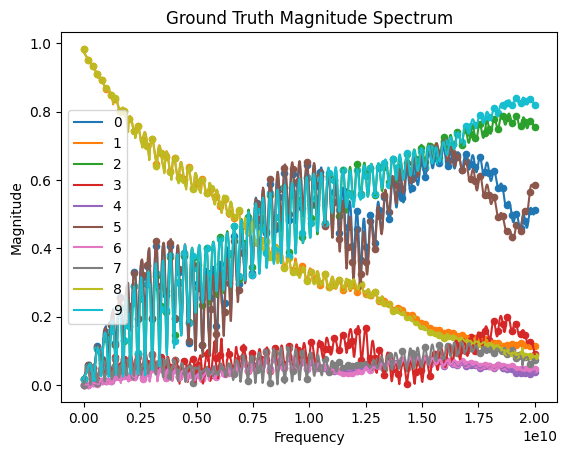

In [15]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
    plt.scatter(y_freqs, y_mag[0, i].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

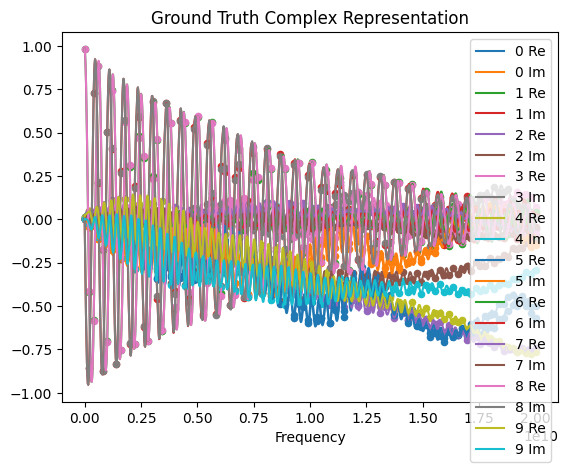

In [16]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
    plt.scatter(y_freqs, y[0,2*i].cpu(), s=20)
    plt.scatter(y_freqs, y[0,2*i+1].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

torch.Size([1, 20, 997])


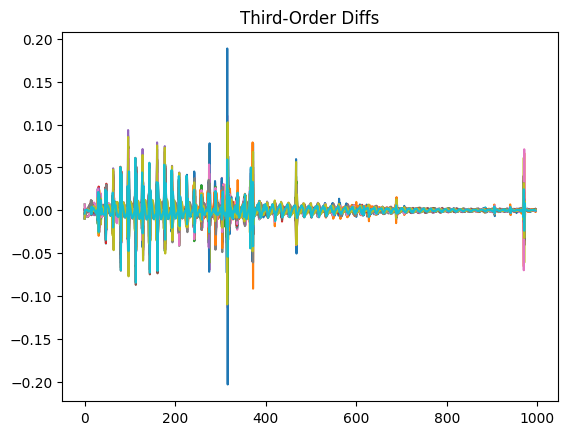

In [17]:
@torch.no_grad()
def calc_diffs(x, order=1):
    if order > 1:
        x = calc_diffs(x, order-1)
    
    if isinstance(x, np.ndarray):
        return (x - np.roll(x, -1, 2))[...,:-1] 
    elif torch.is_tensor(x):
        return (x - torch.roll(x, -1, 2))[...,:-1]

x_diff_2 = calc_diffs(x, 3)

print(x_diff_2.shape)

plt.figure()
for i in range(x_diff_2.shape[1]//2):
    plt.plot(x_diff_2[0,2*i,:].squeeze().cpu(), label=str(i)+" Re")
    plt.plot(x_diff_2[0,2*i+1,:].squeeze().cpu(), label=str(i)+" Im")
plt.title("Third-Order Diffs")
plt.show()

# 2. Network Setup

## Define network parameters

In [18]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 5

if NZ < 16:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 2) #third power of two after NZ 
elif NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NC = y.shape[1]

KERNEL_SIZE = 3
CAUSAL = True
PASSIVE = False

In [19]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("CAUSAL: ", CAUSAL)
print("PASSIVE: ", PASSIVE)

NZ:  20
NUM_LAYERS:  5
BASE NGF:  64
NC:  20
KERNEL_SIZE:  3
CAUSAL:  True
PASSIVE:  False


## Init and check dimensions

In [20]:
from models import RESNET_BACKBONE, RESNET_HEAD, MODULAR_RESNET

net_backbone = RESNET_BACKBONE(ngf=BASE_NGF,
                               ngf_in_out=BASE_NGF,
                               kernel_size=KERNEL_SIZE,
                               num_layers=NUM_LAYERS)
net_head = RESNET_HEAD(nz=NZ,
                       ngf_in_out=BASE_NGF,
                       nc=NC,
                       output_size=N_FREQS,
                       kernel_size=KERNEL_SIZE,
                       causal=CAUSAL,
                       passive=PASSIVE)

net = MODULAR_RESNET(backbone=net_backbone,
                     head=net_head)
net = net.to(device)

In [21]:
z_temp = torch.randn((1, NZ, N_FREQS)).to(device)

test_out = net.forward(z_temp)

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 1000])


In [22]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  401496


# Define Running Functions and Stuff

In [23]:
LR = 2e-4 
NUM_ITER = 10000 

REG_HYPERPARAM = 1.0
REG_TYPE = "smoothing"
REG_TARGET = None #this is only sety if we are using centered_wd regularisation
REG_ORDER = 3
REG_NORM = 2

# REG_HYPERPARAM = 1e-2
# REG_TYPE = "wd"
# REG_TARGET = None #this is only sety if we are using centered_wd regularisation
# REG_ORDER = None
# REG_NORM = None

# REG_HYPERPARAM = 1e-5
# REG_TYPE = "centered_wd"
# REG_TARGET = None #this is only sety if we are using centered_wd regularisation
# REG_ORDER = None
# REG_NORM = None

REDUCTION = "mean"

In [24]:
START_NOISE_LEVEL = 1
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

print("Noise decay factor: ", NOISE_DECAY_FACTOR)

# START_NOISE_LEVEL = None
# NOISE_DECAY_FACTOR = None

Noise decay factor:  0.9993094630025899


In [25]:
# SGLD = False
# BURN_IN_ITER = 5000
# SAVE_OUTPUT_EVERY = 1

SGLD = True
BURN_IN_ITER = 5000
SAVE_OUTPUT_EVERY = 100

In [26]:
import Fitting

dip_args = {"y": y,
            "x": x,
            "z": z,
            "device": device,
            "model": net,
            "lr": LR,
            "num_iter": NUM_ITER,
            "reg_type": REG_TYPE,
            "reg_lambda": REG_HYPERPARAM,
            "reg_target": REG_TARGET,
            "reg_order": REG_ORDER,
            "reg_norm": REG_NORM,
            "reduction": REDUCTION,
            "kept_inds": kept_inds,
            "input_noise_start": START_NOISE_LEVEL,
            "input_noise_decay": NOISE_DECAY_FACTOR,
            "perturb_weights": SGLD,
            "burn_in_iter": BURN_IN_ITER,
            "save_output_every": SAVE_OUTPUT_EVERY,
            "debug": True}
dip_args = Fitting.dict2namespace(dip_args)

In [27]:
dip_results = Fitting.run_dip(dip_args)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:
print("Final MSE: ", dip_results.mse_list_gt[-1])
print("Final Mean MSE: ", dip_results.mse_list_mean_gt[-1])

Final MSE:  0.0004319960135035217
Final Mean MSE:  0.00046041011228226125


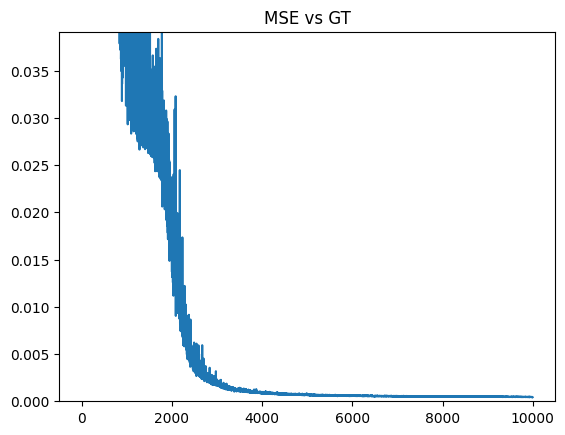

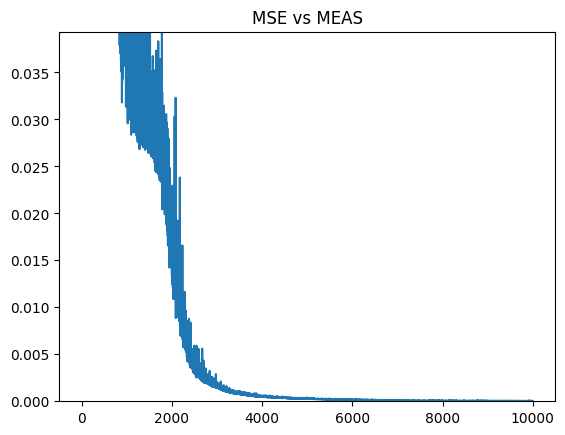

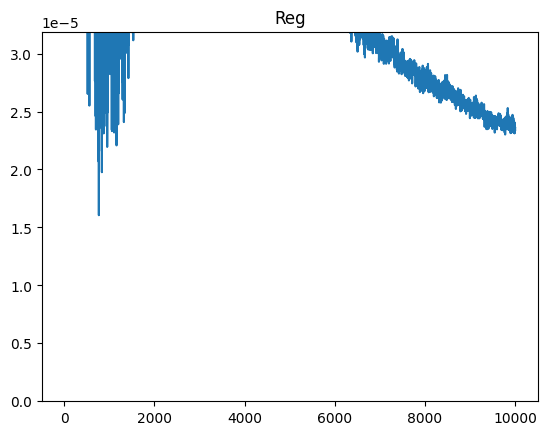

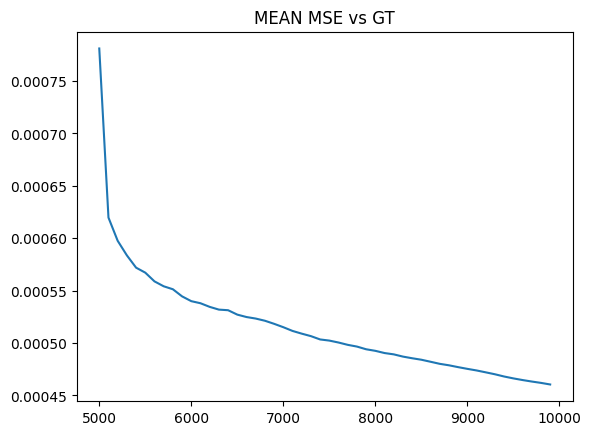

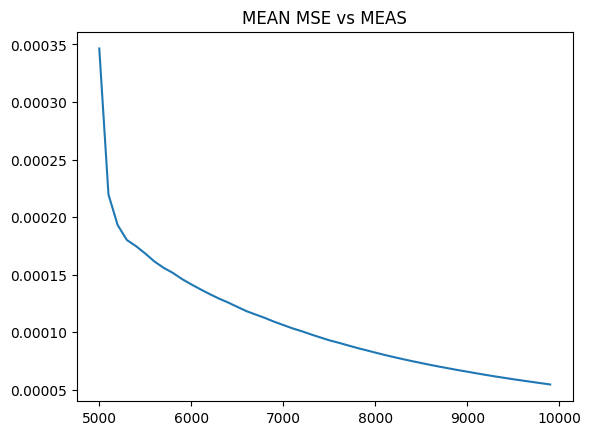

In [29]:
MAX_IDX = 1000

plt.figure()
plt.plot(dip_results.mse_list_gt)
plt.title("MSE vs GT")
plt.ylim(0, dip_results.mse_list_gt[MAX_IDX])
plt.show()

plt.figure()
plt.plot(dip_results.mse_list_meas)
plt.title("MSE vs MEAS")
plt.ylim(0, dip_results.mse_list_meas[MAX_IDX])
plt.show()

if hasattr(dip_results, "reg_list"):
    plt.figure()
    plt.plot(dip_results.reg_list)
    plt.title("Reg")
    plt.ylim(0, dip_results.reg_list[MAX_IDX])
    plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_gt)
plt.title("MEAN MSE vs GT")
plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_meas)
plt.title("MEAN MSE vs MEAS")
plt.show()

In [30]:
out_mag_list = [utils.sparams_to_mag(i) for i in dip_results.out_list]

mean_out_mag = torch.mean(torch.cat(out_mag_list), dim=0, keepdim=True)
std_out_mag = torch.std(torch.cat(out_mag_list), dim=0, keepdim=True)

In [31]:
last_out = dip_results.out_list[-1]

last_out_mag = utils.sparams_to_mag(last_out)

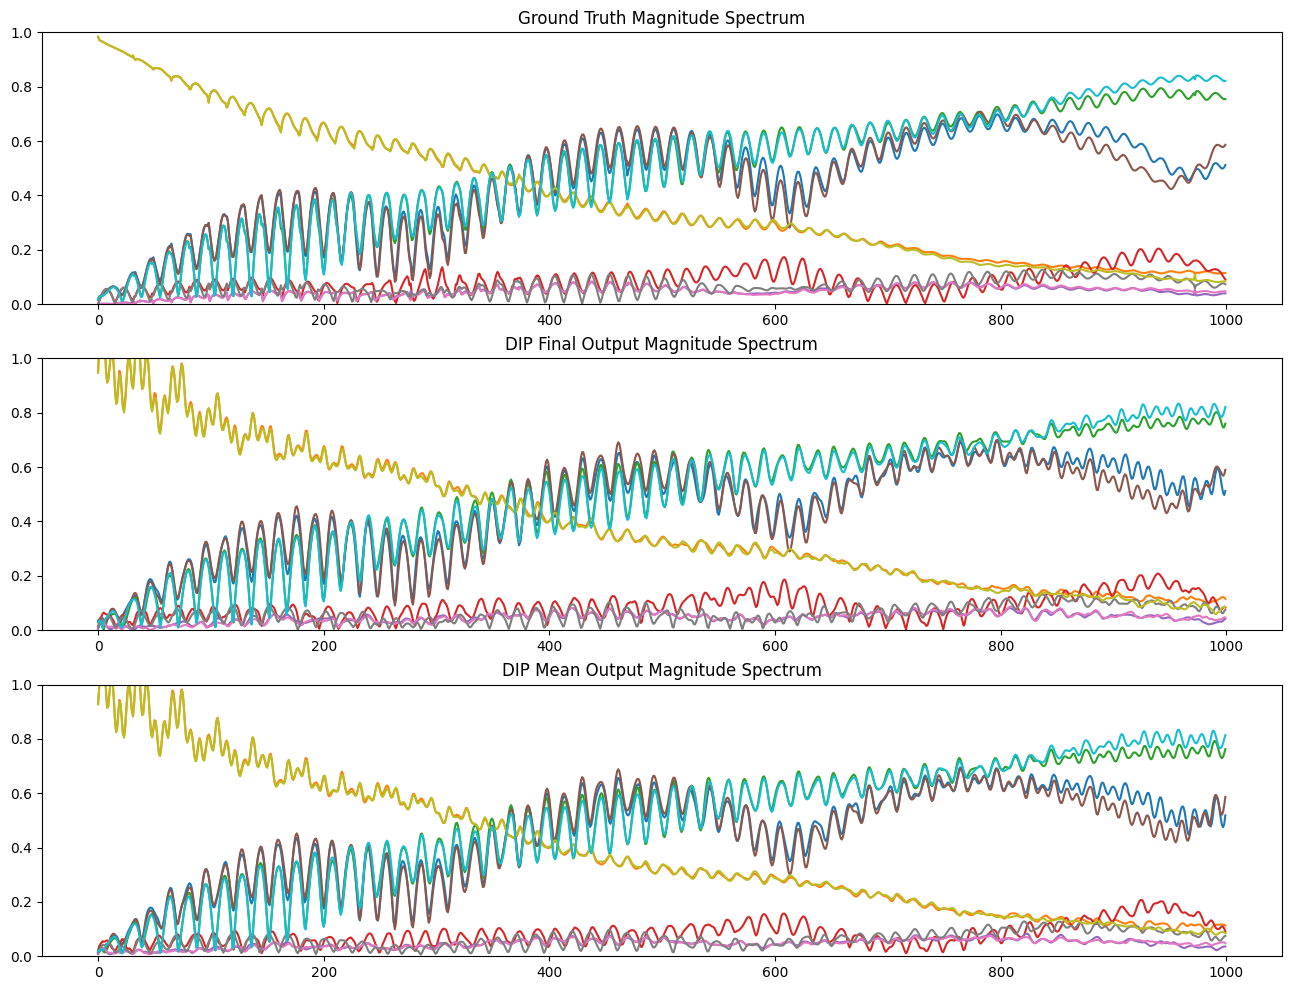

In [32]:
_, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(x_mag.shape[1]):
    axes[0].plot(x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[1].plot(last_out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Final Output Magnitude Spectrum")
axes[1].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[2].plot(mean_out_mag[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Mean Output Magnitude Spectrum")
axes[2].set_ylim(0,1)

plt.show()

Text(0.5, 1.0, 'Mean')

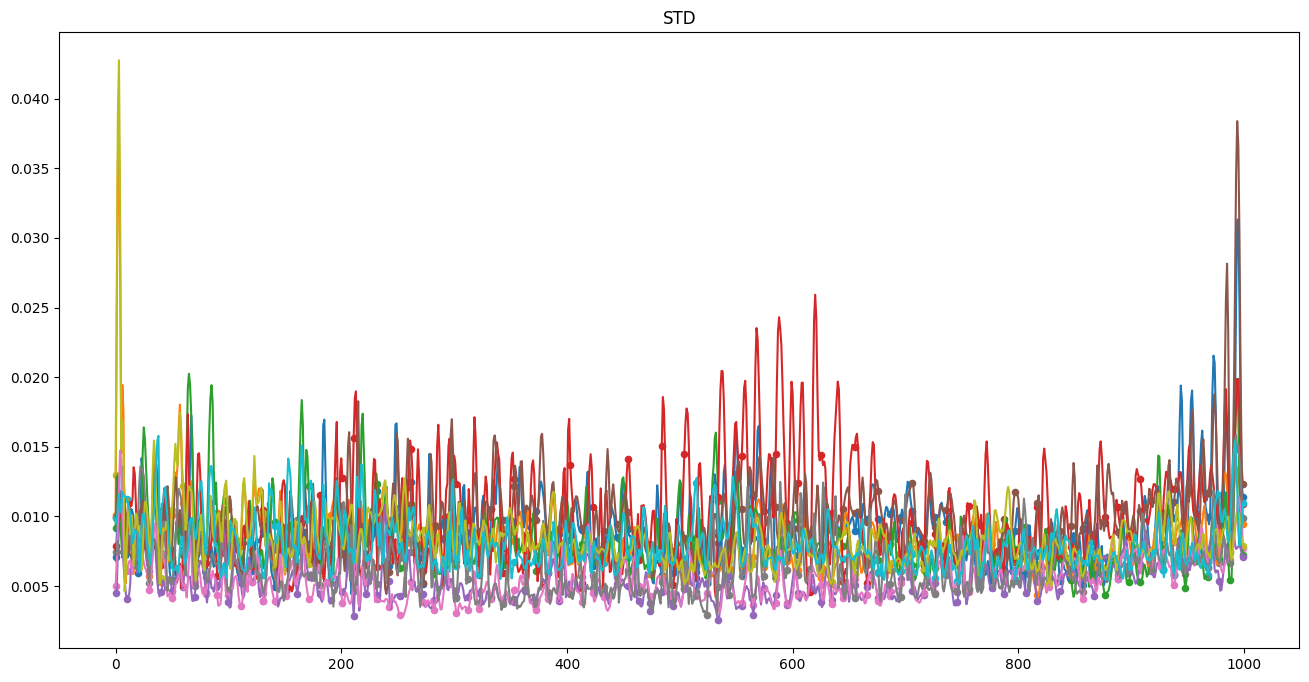

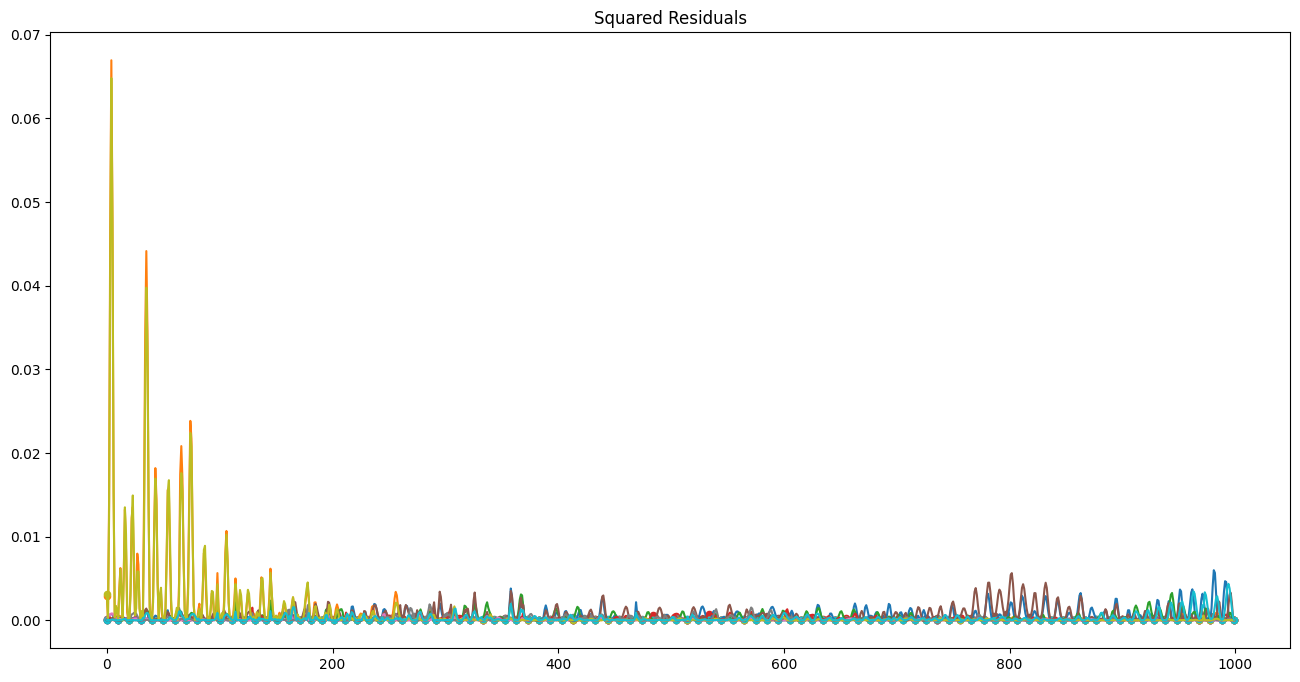

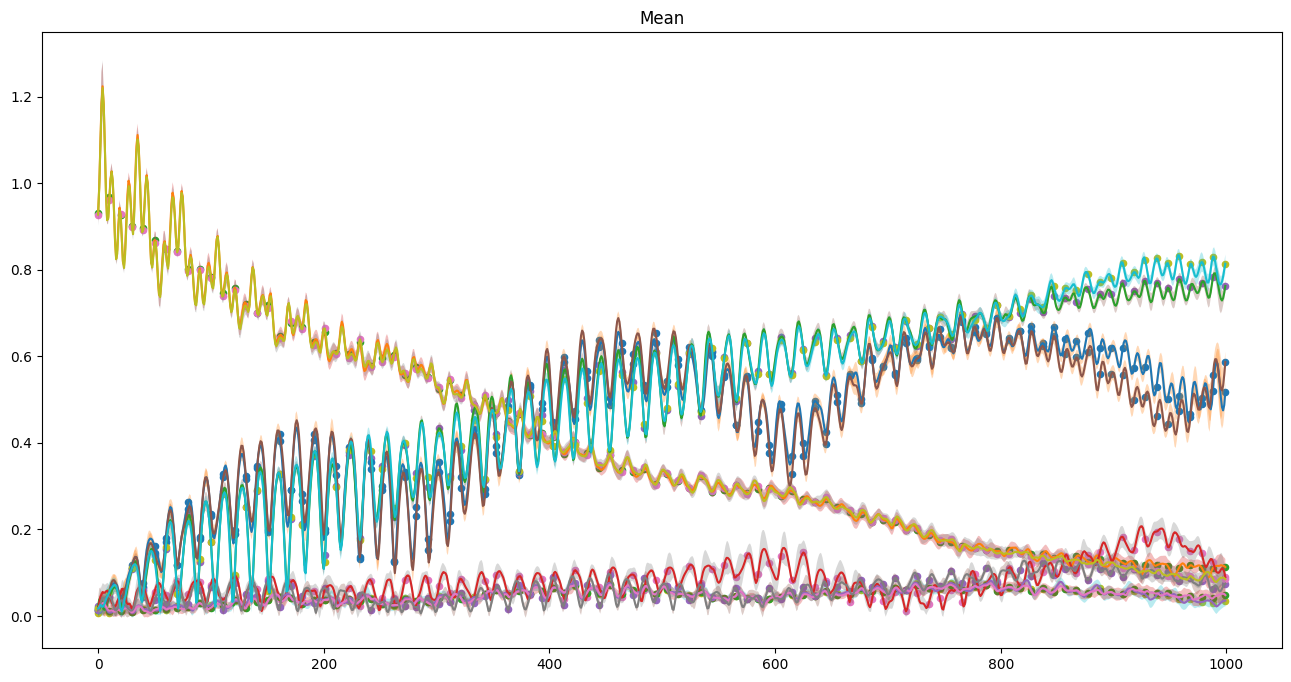

In [33]:
under_line = mean_out_mag - 1.96*std_out_mag
over_line = mean_out_mag + 1.96*std_out_mag

resid_mag = torch.square(x_mag - mean_out_mag)

plt.figure(figsize=(16,8))
for i in range(std_out_mag.shape[1]):
    plt.plot(std_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, std_out_mag[0,i][kept_inds].detach().cpu(), s=20)
plt.title("STD")

plt.figure(figsize=(16,8))
for i in range(resid_mag.shape[1]):
    plt.plot(resid_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, resid_mag[0,i][kept_inds].detach().cpu(), s=20)
plt.title("Squared Residuals")

plt.figure(figsize=(16,8))
for i in range(mean_out_mag.shape[1]):
    plt.plot(np.arange(N_FREQS), mean_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, mean_out_mag[0,i][kept_inds].detach().cpu(), s=20)
    plt.fill_between(np.arange(N_FREQS), under_line[0,i].detach().cpu(), over_line[0,i].detach().cpu(), alpha=0.3)
plt.title("Mean")